In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
import matplotlib.dates as mdates
from typing import List
import os

In [ ]:
class WattsupDataProcessing:
    def __init__(self, root_directory, run_directory_prefix):
        self.root_directory = root_directory
        self.run_directory_prefix = run_directory_prefix
        self.runs_dict = {}

    def convertEpochToTimestamp(self, epochSinceMs):
        timestamp = pd.to_datetime(int(epochSinceMs), unit='ms')
        return timestamp.replace(microsecond=0)

    def process(self, file1, file2, run_number, sample):
        GL2_df = pd.read_csv(file1, delimiter="\s+", names=["timestamp", "power"], usecols=[0, 2])
        GL3_df = pd.read_csv(file2, delimiter="\s+", names=["timestamp", "power"], usecols=[0, 2])

        GL2_df["timestamp"] = GL2_df["timestamp"].apply(self.convertEpochToTimestamp)
        GL3_df["timestamp"] = GL3_df["timestamp"].apply(self.convertEpochToTimestamp)

        merged_df = pd.merge(GL2_df, GL3_df, left_on="timestamp", right_on="timestamp")
        merged_df["power"] = merged_df["power_x"] + merged_df["power_y"]
        sample_name = sample[:-4]

        result_df = merged_df[["timestamp", "power"]]
        os.makedirs(f"{self.root_directory}/processed-results/wattsup/run_{run_number}/", exist_ok=True)

        result_df.to_csv(f'{self.root_directory}/processed-results/wattsup/run_{run_number}/{sample_name}.csv')

    def process_runs(self):
        for run_number, samples in self.runs_dict.items():
            root_dir1 = f"{self.root_directory}/results/train-ticket/GL3/{run_number}/"

            for sample in samples:
                file_path = f"{self.root_directory}/results/train-ticket/GL2/{run_number}/{sample}"
                file_path1 = f"{root_dir1}/{sample}"
                self.process(file_path, file_path1, run_number, sample)

root_directory = "/home/gabriela/Desktop/VU/thesis2023/results/train-ticket/GL2/"
run_directory_prefix = "run_"

data_preprocessing = WattsupDataProcessing(root_directory, run_directory_prefix)
data_preprocessing.process_runs()

In [40]:
import os
import pandas as pd

class SmartwattsDataProcessing:
    def __init__(self, root_directory):
        self.root_directory = root_directory

    def convertEpochToTimestamp(self, epochSinceMs):
        timestamp = pd.to_datetime(int(epochSinceMs), unit='ms')
        return timestamp.replace(microsecond=0)

    def computeTotalPower(self, run_number, workload):
        output_file = f'{self.root_directory}/processed-results/smartwatts/run_{run_number}/run_{run_number}-{workload}.csv'
        timestamp_power = {}

        subdirectories_path = os.path.join(self.root_directory, f'run_{run_number}/run_{run_number}-{workload}')
        subdirectories = [subdir for subdir in os.listdir(subdirectories_path) if subdir.startswith('cpu-train-ticketing-system')]

        for subdir in subdirectories:
            subdir_path = os.path.join(subdirectories_path, subdir)
            power_report_file = os.path.join(subdir_path, 'PowerReport.csv')
            df = pd.read_csv(power_report_file)
            df["timestamp"] = df["timestamp"].apply(self.convertEpochToTimestamp)
            df_resampled = df.set_index('timestamp').resample('1S').first()

            for timestamp, power in zip(df_resampled.index, df_resampled['power']):
                if not pd.isna(power): 
                    if timestamp in timestamp_power:
                        timestamp_power[timestamp] += power
                    else:
                        timestamp_power[timestamp] = power

        output_df = pd.DataFrame(list(timestamp_power.items()), columns=['timestamp', 'total_power'])
        output_df.sort_values(by='timestamp', inplace=True)

        output_df.to_csv(output_file, index=False)
        print(f"Output file '{output_file}' has been created.")

    def process_runs(self):
        for run_number in range(0, 61):
            if run_number not in [2, 9, 13, 14, 16, 20, 29, 33, 46, 49, 54]:
                self.computeTotalPower(run_number, 'HIGH')
                self.computeTotalPower(run_number, 'MEDIUM')
                self.computeTotalPower(run_number, 'LOW')

root_directory = '/home/gabriela/Desktop/VU/thesis2023/results/smartwatts'
smartwatts_processing = SmartwattsDataProcessing(root_directory)
smartwatts_processing.process_runs()

Output file 'processed-results/smartwatts/run_0/run_0-HIGH.csv' has been created.
Output file 'processed-results/smartwatts/run_0/run_0-MEDIUM.csv' has been created.
Output file 'processed-results/smartwatts/run_0/run_0-LOW.csv' has been created.
Output file 'processed-results/smartwatts/run_1/run_1-HIGH.csv' has been created.
Output file 'processed-results/smartwatts/run_1/run_1-MEDIUM.csv' has been created.
Output file 'processed-results/smartwatts/run_1/run_1-LOW.csv' has been created.
Output file 'processed-results/smartwatts/run_3/run_3-HIGH.csv' has been created.
Output file 'processed-results/smartwatts/run_3/run_3-MEDIUM.csv' has been created.
Output file 'processed-results/smartwatts/run_3/run_3-LOW.csv' has been created.
Output file 'processed-results/smartwatts/run_4/run_4-HIGH.csv' has been created.
Output file 'processed-results/smartwatts/run_4/run_4-MEDIUM.csv' has been created.
Output file 'processed-results/smartwatts/run_4/run_4-LOW.csv' has been created.
Output file 

In [243]:
import os
import pandas as pd

wattsup_dir = '/home/gabriela/Desktop/VU/thesis2023/processed-results/wattsup/'
smartwatts_dir = '/home/gabriela/Desktop/VU/thesis2023/processed-results/smartwatts/'

# Destination directory
merged_dir = '/home/gabriela/Desktop/VU/thesis2023/processed-results/merged-power-measurements/'

run_numbers = []
for i in range(0,61):
    if i not in [2,9,13,14,16,20,29,33,46,49,54]:
        run_numbers.append(i)

workload_levels = ['HIGH', 'MEDIUM', 'LOW']

for run_number in run_numbers:
    for workload in workload_levels:
        wattsup_subdir = os.path.join(wattsup_dir, f'run_{run_number}/')
        smartwatts_subdir = os.path.join(smartwatts_dir, f'run_{run_number}/')

        wattsup_files = [file for file in os.listdir(wattsup_subdir) if workload in file]
        smartwatts_files = [file for file in os.listdir(smartwatts_subdir) if workload in file]
        for sw_file in smartwatts_files:
            sample_name = sw_file[:-4]  # Remove the '.csv' extension

            watts_file = next((file for file in wattsup_files if sample_name in file), None)

            if watts_file:
                file_wattsup = os.path.join(wattsup_subdir, watts_file)
                file_smartwatts = os.path.join(smartwatts_subdir, sw_file)

                df_wattsup = pd.read_csv(file_wattsup)
                df_smartwatts = pd.read_csv(file_smartwatts)

                # Align the data based on timestamp
                merged_df = pd.merge(df_wattsup, df_smartwatts, on='timestamp', how='inner')
                merged_df.rename(columns={'power': 'wattsup_power', 'total_power': 'smartwatts_power'}, inplace=True)

                output_dir = os.path.join(merged_dir, f'run_{run_number}')
                os.makedirs(output_dir, exist_ok=True)
                output_file = os.path.join(output_dir, f'{sample_name}.csv')

                merged_df.to_csv(output_file, index=False)
                print(f"Merged DataFrame for sample '{sample_name}' has been saved.")



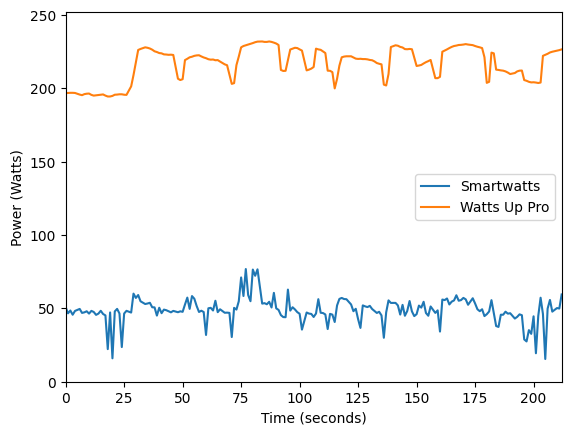

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import os

class PowerDataAnalyzer:
    def __init__(self, data_file, root_directory):
        self.df = pd.read_csv(data_file)
        self.root_directory = root_directory
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        self.df['time_elapsed'] = (self.df['timestamp'] - self.df['timestamp'].iloc[0]).dt.total_seconds()
        self.workloads = ['HIGH', 'MEDIUM', 'LOW']
        self.run_numbers = []

        # Filtering the successful runs
        for i in range(0,61):
            if i not in [2,9,13,14,16,20,29,33,46,49,54]:
                self.run_numbers.append(i)
        
    def plot_power_comparison(self, num_data_points=200):
        plt.plot(self.df['time_elapsed'][:num_data_points], self.df['smartwatts_power'][:num_data_points], label = 'Smartwatts')
        plt.plot(self.df['time_elapsed'][:num_data_points], self.df['wattsup_power'][:num_data_points], label = 'Watts Up Pro')

        plt.xlabel('Time (seconds)')
        plt.ylabel('Power (Watts)')

        x_min = self.df['time_elapsed'][:num_data_points].min()
        x_max = self.df['time_elapsed'][:num_data_points].max()
        plt.xlim(x_min, x_max)

        y_upper_bound = self.df['wattsup_power'][:num_data_points].max() + 20
        plt.ylim(0, y_upper_bound)

        plt.legend()
        return plt

    
    def get_files_by_workload(self, run_number, workload):
        run_directory = os.path.join(self.root_directory, f'run_{run_number}')
        return os.path.join(run_directory, f'run_{run_number}-{workload}.csv')

    # Calculate the error rate for each workload
    def compute_error_rate(self, workload_files):
        dfs = {}
        for workload, files in workload_files.items():
            workload_dfs = []
            for file in files:
                df = pd.read_csv(file)
                df = df.drop(df.columns[0], axis=1)
                workload_dfs.append(df)
            merged_df = pd.concat(workload_dfs)
            dfs[workload] = merged_df

        for workload, df in dfs.items():
            df['error_rate'] = abs(df['smartwatts_power'] - df['wattsup_power'])

        return dfs

    def plot_error_rate_boxplot(self, dfs):
        plt.figure()
        plt.boxplot([df['error_rate'] for df in dfs.values()], labels = list(dfs.keys()), whis=3.5)

        plt.ylabel('Energy (J)')
        plt.show()

    def get_error_df(self):
        sample_files = {workload: [] for workload in self.workloads}
        for run_number in self.run_numbers:
            for workload in self.workloads:
                sample_files[workload].append(self.get_files_by_workload(run_number, workload))

        # Read the CSV files for each workload and create separate DataFrames
        workload_files = {
            'High': sample_files['HIGH'],
            'Medium': sample_files['MEDIUM'],
            'Low': sample_files['LOW']
        }

        dfs = self.compute_error_rate(workload_files)
        return dfs

workload = 'LOW'
root_directory = '/home/gabriela/Desktop/VU/thesis2023/processed-results/merged-power-measurements/'
data_file = f'/home/gabriela/Desktop/VU/thesis2023/processed-results/merged-power-measurements/run_10/run_10-{workload}.csv'
analyzer = PowerDataAnalyzer(data_file, root_directory)
power_comparison_plot = analyzer.plot_power_comparison(200)
# power_comparison_plot.savefig(f'power-comparison-{workload}.png')


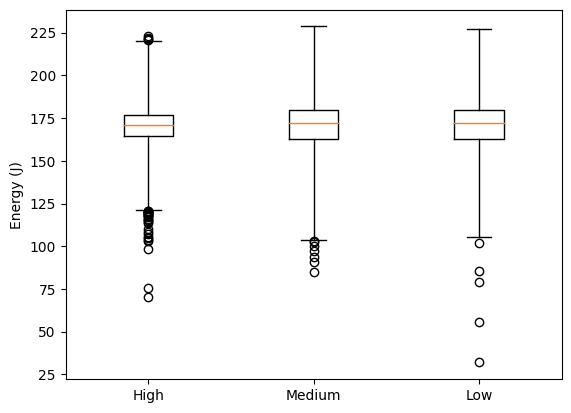

In [5]:
error_df = analyzer.get_error_df()
analyzer.plot_error_rate_boxplot(error_df)

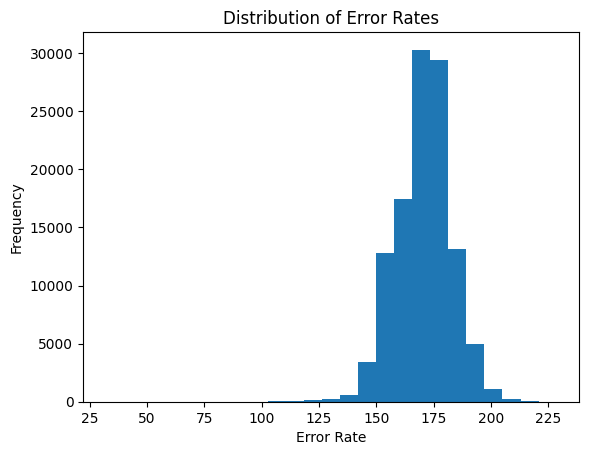

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dfs = analyzer.get_error_df()

combined_df = pd.concat(dfs.values())

plt.hist(combined_df['error_rate'], bins=25)

plt.xlabel('Error Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Error Rates')

plt.show()


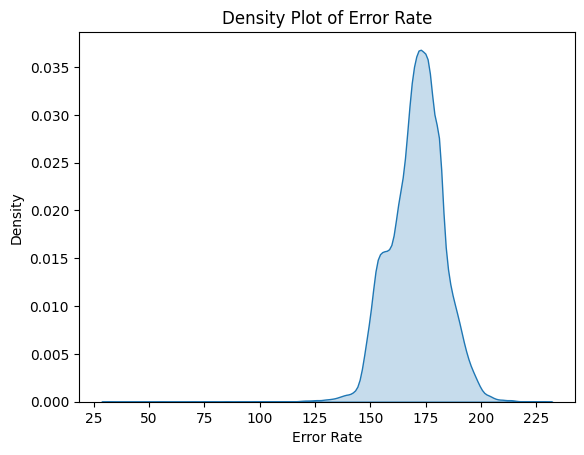

In [8]:
import seaborn as sns

sns.kdeplot(combined_df['error_rate'], fill=True)

plt.xlabel('Error Rate')
plt.ylabel('Density')
plt.title('Density Plot of Error Rate')

plt.show()

In [270]:
dfs = analyzer.get_error_df()

df_high = dfs['High']
df_high['workload'] = 'HIGH'
df_medium = dfs['Medium']
df_medium['workload'] = 'MEDIUM'
df_low = dfs['Low']
df_low['workload'] = "LOW"

import numpy as np
from scipy.integrate import trapz


def get_energy_df(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    time_diff = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds()

    # Convert 'smartwatts_power' and 'wattsup_power' columns to energy
    df['smartwatts_energy'] = np.round(trapz(df['smartwatts_power'], time_diff), 0)
    df['wattsup_energy'] = np.round(trapz(df['wattsup_power'], time_diff), 0)

    res = pd.DataFrame({
        'workload': [list(df['workload'])[0]],
        'smartwatts_energy': [list(df['smartwatts_energy'])[0]],
        'wattsup_energy': [list(df['wattsup_energy'])[0]]
    })    
    return res


In [286]:
root_directory = '~/Desktop/VU/thesis2023/processed-results/'

def get_files_by_workload(run_number, workload):
    run_directory = os.path.join(root_directory, f'merged-power-measurements/run_{run_number}')
    return os.path.join(run_directory, f'run_{run_number}-{workload}.csv')


def read_and_get_energy_df(run_number, workload):
    df = pd.read_csv(get_files_by_workload(run_number, workload))
    df['workload'] = workload
    energy_df = get_energy_df(df)
    energy_df['run_number'] = run_number    
    return energy_df

main_df = pd.DataFrame()
workloads = ['HIGH', 'MEDIUM', 'LOW']

for run_number in run_numbers:
    run_df = pd.DataFrame()
    energy_dfs = [read_and_get_energy_df(run_number, workload) for workload in workloads]
    run_df = pd.concat([run_df] + energy_dfs, ignore_index=True)
    main_df = pd.concat([main_df, run_df], ignore_index=True)
    run_df.to_csv(f"{root_directory}/energy-measurements/run_{run_number}-energy.csv", index=False)

main_df.to_csv("combined-energy.csv", index=False)


In [8]:
from scipy.stats import pearsonr

main_df = pd.read_csv('combined-energy.csv')
high = main_df[main_df['workload'] == 'HIGH']
medium = main_df[main_df['workload'] == 'MEDIUM']
low = main_df[main_df['workload'] == 'LOW']

def perform_correlation_test(energy_df):
    x = energy_df['smartwatts_energy']
    y = energy_df['wattsup_energy']

    # Compute the correlation coefficient using pearsonr
    correlation, p_value = pearsonr(x, y)
    return energy_df['workload'],correlation, p_value

results=[]
for workload in [high, medium, low]:
    results.append(perform_correlation_test(workload))

df_results = pd.DataFrame(results, columns=['Workload', 'Correlation Coefficient', 'P-value'])
df_results['Workload'] = ['HIGH', 'MEDIUM', 'LOW']
df_results['Correlation Coefficient'] = df_results['Correlation Coefficient'].round(3)
df_results

# table = df_results.to_latex(index=True, formatters={'P-value': '{:.2e}'.format})
# print(table)

,Workload,Correlation Coefficient,P-value
0,HIGH,0.809,1.154089e-12
1,MEDIUM,0.758,1.786026e-10
2,LOW,0.827,1.317914e-13


In [280]:
def generate_summary(df):
    summary = df.drop(columns='run_number').describe().drop(labels='count')
    summary['smartwatts_energy'] = summary['smartwatts_energy'].astype(int)
    summary['wattsup_energy'] = summary['wattsup_energy'].astype(int)
    summary = summary.rename(columns={'smartwatts_energy': 'SmartWatts', 'wattsup_energy': 'Wattsup Pro'})
    summary = summary.rename_axis('Power meter', axis=0)
    transposed_summary = summary.transpose().rename(columns=str.capitalize)
    transposed_summary['CV'] = (transposed_summary['Std'] / transposed_summary['Mean']) * 100
    transposed_summary['CV'] =  transposed_summary['CV'].round(2)
    return transposed_summary

low = main_df[main_df['workload'] == 'LOW']
medium = main_df[main_df['workload'] == 'MEDIUM']
high = main_df[main_df['workload'] == 'HIGH']

low_workload_summary = generate_summary(low)
medium_workload_summary = generate_summary(medium)
high_workload_summary = generate_summary(high)

low_workload_summary

Power meter,Mean,Std,Min,25%,50%,75%,Max,CV
SmartWatts,31376,5757,19658,27376,30679,36770,40964,18.35
Wattsup Pro,170404,20955,129951,166819,179690,184678,199102,12.30


In [323]:
medium_workload_summary

Power meter,Mean,Std,Min,25%,50%,75%,Max,CV
SmartWatts,31823,4007,24155,29398,31258,34521,39693,12.59
Wattsup Pro,173972,16481,135479,174783,180131,183528,189066,9.47


In [324]:
high_workload_summary

Power meter,Mean,Std,Min,25%,50%,75%,Max,CV
SmartWatts,36315,3448,27053,34735,36941,38827,43018,9.49
Wattsup Pro,178680,15673,135041,180389,184301,186046,193072,8.77
